# **Installs**

In [ ]:
!pip install photutils --quiet
!pip install webbpsf --quiet

In [ ]:
!wget https://stsci.box.com/shared/static/qxpiaxsjwo15ml6m4pkhtk36c9jgj70k.gz -O webbpsf-data-1.2.1.tar.gz

In [ ]:
!tar -xf webbpsf-data-1.2.1.tar.gz

In [ ]:
!rm webbpsf-data-1.2.1.tar.gz

In [ ]:
!pip uninstall numexpr --quiet -y

# **Imports**

In [1]:
import sys
import time
import numpy as np
import pandas as pd
import glob as glob
import urllib.request
import tarfile
import os

from scipy.ndimage import gaussian_filter

from astropy.io import fits
from astropy.visualization import simple_norm
from astropy.nddata import NDData
from astropy.wcs import WCS
from astropy.modeling import models, fitting
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.table import Table, QTable
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u
from astropy.stats import SigmaClip, sigma_clipped_stats, gaussian_fwhm_to_sigma
from astropy.convolution import Gaussian2DKernel, convolve_fft
from astropy.nddata.utils import Cutout2D

import photutils as phot
from photutils.background import MMMBackground, MADStdBackgroundRMS, Background2D, LocalBackground
from photutils.detection import DAOStarFinder
from photutils.psf import EPSFBuilder, GriddedPSFModel
from photutils.psf import SourceGrouper, extract_stars, IterativePSFPhotometry, DAOPhotPSFPhotometry

from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry


In [2]:
os.environ['WEBBPSF_PATH'] = '../data/webbpsf-data'

In [3]:
%matplotlib inline
from matplotlib import style, pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import matplotlib.colors as col
from matplotlib.colors import ListedColormap
import seaborn as sb
sb.set_style('white')
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['figure.figsize'] = (12,12)
plt.rcParams['axes.titlesize'] = plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 15

font1 = {'family': 'sans-serif', 'color': 'black', 'weight': 'normal', 'size': '15'}
font2 = {'family': 'sans-serif', 'color': 'black', 'weight': 'normal', 'size': '20'}

In [4]:
import webbpsf
from webbpsf.utils import to_griddedpsfmodel

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-062 CANNOT BE CHECKED AGAINST ONLINE VERSION


In [5]:
""" Simulated (Webb PSF)
filters = ['F070W', 'F090W', 'F115W', 'F140M', 'F150W2','F150W', 'F162M', 'F164N', 'F182M',
           'F187N', 'F200W', 'F210M', 'F212N', 'F250M', 'F277W', 'F300M', 'F322W2','F323N',
           'F335M', 'F356W', 'F360M', 'F405N', 'F410M', 'F430M', 'F444W', 'F460M', 'F466N', 'F470N', 'F480M']

psf_fwhm = [0.987,   1.103,   1.298,   1.553,   1.628,   1.770,   1.801,   1.494,   1.990, 
            2.060,   2.141,   2.304,   2.341,   1.340,   1.444,   1.585,   1.547,   1.711, 
            1.760,   1.830,   1.901,   2.165,   2.179,   2.300,   2.302,   2.459,   2.507, 2.535, 2.574]

dict_utils = {filters[i]: {'psf fwhm': psf_fwhm[i]} for i in range(len(filters))}
""";

In [6]:
# Empirical (Rigby et al. 2022). https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-performance/nircam-point-spread-functions
filters = ['F070W', 'F090W', 'F115W', 'F140M', 'F150W2','F150W', 'F162M', 'F164N', 'F182M',
           'F187N', 'F200W', 'F210M', 'F212N', 'F250M', 'F277W', 'F300M', 'F322W2','F323N',
           'F335M', 'F356W', 'F360M', 'F405N', 'F410M', 'F430M', 'F444W', 'F460M', 'F466N', 'F470N', 'F480M']

psf_fwhm = [0.935,   1.065,   1.290,   1.548,   1.628,   1.613,   1.774,   1.806,   2.000, 
            2.065,   2.129,   2.290,   2.323,   1.349,   1.460,   1.587,   1.547,   1.714, 
            1.762,   1.841,   1.905,   2.159,   2.175,   2.286,   2.302,   2.492,   2.508, 2.540, 2.603]

dict_utils = {filters[i]: {'psf fwhm': psf_fwhm[i]} for i in range(len(filters))}

# **Synthetic PSF using Webb PSF**

In [7]:
psfs_dir = 'PSF_MODELS/'

if not os.path.exists(psfs_dir):
    os.makedirs(psfs_dir)

def create_psf_model(det='NRCA1', filt='F070W', fov=101, source=None,
                     create_grid=False, num=9, save_psf=False,
                     detsampled=False,all_detectors=False):

    nrc = webbpsf.NIRCam()

    nrc.detector = det
    nrc.filter = filt

    print("Using a {field}".format(field=fov), "px fov")

    if create_grid:
        print("")
        print("Creating a grid of PSF for filter {filt} and detector {det}".format(filt=filt, det=det))
        print("")
        num = num

        if save_psf:

            outname = 'PSF_%s_samp4_fov%d_npsfs%d.fits' % (filt, fov, num)
            psf = nrc.psf_grid(num_psfs=num, oversample=4, source=source, all_detectors=all_detectors,fov_pixels=fov,
                               save=True, outfile=os.path.join(psfs_dir,outname), use_detsampled_psf=detsampled)

        else:

            psf = nrc.psf_grid(num_psfs=num, oversample=4, source=source, all_detectors=False, fov_pixels=fov,
                               use_detsampled_psf=detsampled)

    else:
        print("")
        print("Creating a single PSF for filter {filt} and detector {det}".format(filt=filt, det=det))
        print("")
        num = 1

        if save_psf:

            outname = 'PSF_%s_samp4_fov%d_npsfs%d.fits' % (filt, fov, num)
            psf = nrc.psf_grid(num_psfs=num, oversample=4, source=source, all_detectors=False, fov_pixels=fov,
                               save=True, outfile=os.path.join(psfs_dir,outname), use_detsampled_psf=detsampled)

        else:

            psf = nrc.psf_grid(num_psfs=num, oversample=4, source=source, all_detectors=False, fov_pixels=fov,
                               use_detsampled_psf=detsampled)

    return psf

# **Empirical PSF**

In this section we explore how to construct an empirical PSF from the data using Astropy and Photutils

## **Source Detection**

As a first step to empirical PSF construction we select the stars using which we will be constructing the PSF. We use Photutils Backgound2D for estimating the background and create background subtracted image for employing DAOStarFinder for detecting sources.

In [8]:
def calc_bkg(data, sigma=3.0, box_size=(100,100), filter_size=(3,3)):

    bkgrms = MADStdBackgroundRMS()
    mmm_bkg = MMMBackground()

    #sigma_clip = SigmaClip(sigma=sigma)
    sigma_clip = SigmaClip(sigma=sigma)
    coverage_mask = (data == 0)

    bkg = Background2D(data, box_size, filter_size=filter_size,
                       sigma_clip=sigma_clip, bkg_estimator=mmm_bkg,
                        coverage_mask=coverage_mask, fill_value=0.0)

    data_bkgsub = data.copy()
    data_bkgsub = data_bkgsub - bkg.background

    _, _, std = sigma_clipped_stats(data_bkgsub)

    return data_bkgsub, bkg, std

In [9]:
def find_stars(data, det='NRCA1', filt='F070W', threshold=3, sigma=3.0, sigma_psf=None, smoothen=True, kernel=None,ZP=0):

    if sigma_psf is None:
        sigma_psf = dict_utils[filt]['psf fwhm']

    if smoothen and kernel is not None:
        data = convolve_fft(data, kernel)

    data_bkgsub, bkg, std = calc_bkg(data, sigma)

    daofind = DAOStarFinder(threshold=threshold*std, fwhm=sigma_psf)
    found_stars = daofind(data_bkgsub)
    found_stars['mag'] = ZP + found_stars['mag']

    print('\nNumber of sources found in the image:', len(found_stars))
    print('-------------------------------------\n')

    return found_stars, data_bkgsub,bkg

## **Source Selection**

In this section we select the sources for empirical PSF construction. We want sources which are sufficiently round, sharp and bright. Thus, we apply roundness, sharpness and magnitude cuts based on thier distribuitions.

In [10]:
def select_stars(found_stars, mag_inf, mag_up,round_inf=-0.4, round_sup=0.4, sh_inf=0.78, sh_sup=0.92, min_sep=10):

    mask = ((found_stars['mag'] > mag_inf) & (found_stars['mag'] < mag_up) & (found_stars['roundness2'] > round_inf)
            & (found_stars['roundness2'] < round_sup) & (found_stars['sharpness'] > sh_inf)
            & (found_stars['sharpness'] < sh_sup))

    found_stars_sel = found_stars[mask]
    found_stars_sel_f115w = found_stars_sel

    print('Number of stars selected to build ePSF:', len(found_stars_sel))

    # if we include the separation criteria:

    d = []

    x_tot = found_stars['xcentroid']
    y_tot = found_stars['ycentroid']

    for xx, yy in zip(found_stars_sel['xcentroid'], found_stars_sel['ycentroid']):

        sep = []
        dist = np.sqrt((x_tot - xx)**2 + (y_tot - yy)**2)
        sep = np.sort(dist)[1:2][0]
        d.append(sep)

    found_stars_sel['min distance'] = d
    mask_dist = (found_stars_sel['min distance'] > min_sep)

    found_stars_sel2 = found_stars_sel[mask_dist]

    print('Number of stars selected to build ePSF \
    \nincluding "mimimum distance closest neighbour" selection):', len(found_stars_sel2))

    return found_stars_sel2

In [11]:
def build_epsf(data, det='NRCA1', filt='F070W', size=11, found_table=None, oversample=4, iters=10):

    hsize = size

    x = found_table['xcentroid']
    y = found_table['ycentroid']

    mask = ((x > hsize) & (x < (data.shape[1] - 1 - hsize)) & (y > hsize) & (y < (data.shape[0] - 1 - hsize)))

    stars_tbl = Table()
    stars_tbl['x'] = x[mask]
    stars_tbl['y'] = y[mask]

    nddata = NDData(data=data)
    stars = extract_stars(nddata, stars_tbl, size=size)

    print('Creating ePSF --- Detector {d}, filter {f}'.format(f=filt, d=det))

    epsf_builder = EPSFBuilder(oversampling=oversample, maxiters=iters, progress_bar=True)

    epsf, fitted_stars = epsf_builder(stars)

    return epsf

# **PSF Photometry using Photutils**

In [12]:
output_phot_dir = './PHOT_OUTPUT/'

if not os.path.exists(output_phot_dir):
    os.makedirs(output_phot_dir)

res_dir = './RESIDUAL_IMAGES/'

if not os.path.exists(res_dir):
    os.makedirs(res_dir)

def psf_phot(data=None, det='NRCA1', filt='F070W', th=2000,
             fit_shape=(11,11),
             sub_shape=(11,11),
             psf=None, ap_radius=5, 
             save_residuals=False,
             header=None,
             save_output=False,
             maxiters=2,min_sep=5,
             ZP=0,
             save_bkg=False):

    fitter = LevMarLSQFitter()
    sigma_clip = SigmaClip(sigma_lower=2.25, sigma_upper=2.00)
    bkgstat = MMMBackground(sigma_clip=sigma_clip)
    localbkg_estimator = LocalBackground(15, 35, bkgstat)

    fwhm_psf = dict_utils[filt]['psf fwhm']
    print('FWHM for filter {f}:'.format(f=filt), fwhm_psf)

    data_bkgsub, bkg, std = calc_bkg(data)

    daofind = DAOStarFinder(threshold=th*std, fwhm=fwhm_psf)

    grouper = SourceGrouper(min_sep*fwhm_psf)

    psf_model = psf.copy()

    print('Performing the PSF photometry --- Detector {d}, filter {f}'.format(f=filt, d=det))
    
    tic = time.perf_counter()

    phot = IterativePSFPhotometry(finder=daofind, grouper=grouper,
                                  localbkg_estimator=localbkg_estimator,
                                  psf_model=psf_model,fitter=fitter,
                                  maxiters=maxiters, fit_shape=fit_shape,
                                  aperture_radius=ap_radius,
                                  sub_shape=sub_shape,
                                  progress_bar=True)
    
    
    result = phot(data_bkgsub)

    toc = time.perf_counter()

    print('Time needed to perform photometry:', '%.2f' % ((toc - tic) / 3600), 'hours')
    print('Number of sources detected:', len(result))

    residual_image = phot.make_residual_image(data_bkgsub, sub_shape)

    # save the residual images as fits file:

    if save_residuals:
        hdu = fits.PrimaryHDU(residual_image, header)
        hdul = fits.HDUList([hdu])

        residual_outname = 'residual_%s_%s.fits' % (det, filt)
        hdul.writeto(os.path.join(res_dir, residual_outname), overwrite=True)


    if save_bkg:
        hdu = fits.PrimaryHDU(bkg.background,header)
        hdul = fits.HDUList([hdu])

        bkg_outname = 'background_%s_%s.fits' % (det, filt)
        hdul.writeto(os.path.join(res_dir, bkg_outname), overwrite=True)

    # save the output photometry Tables

    if save_output:

        outname = 'phot_%s_%s.pkl' % (det, filt)

        tab = result.to_pandas()
        tab.to_pickle(os.path.join(output_phot_dir, outname))

    result['mag'] = ZP -2.5*np.log10(result['flux_fit'])
    result['mag_err'] = 2.5/np.log(10)*result['flux_err']/result['flux_fit']

    return result, residual_image, phot, bkg

# **Pipeline**

## **Input Data**

In [13]:
dict_images = {'NRCA1': {}, 'NRCA2': {}, 'NRCA3': {}, 'NRCA4': {}, 'NRCA5': {},
               'NRCB1': {}, 'NRCB2': {}, 'NRCB3': {}, 'NRCB4': {}, 'NRCB5': {}}

dict_filter_short = {}
dict_filter_long = {}

ff_short = []
det_short = []
det_long = []
ff_long = []
detlist_short = []
detlist_long = []
filtlist_short = []
filtlist_long = []

data_dir = '../data/NGC_628/JWST/'

images_dir = f'{data_dir}'
images = sorted(glob.glob(os.path.join(images_dir, "*/*i2d.fits")))

for image in images:

    im = fits.open(image)
    f = im[0].header['FILTER']
    d = im[0].header['INSTRUME']

    if d == 'NIRCAM':
        d = 'NRCB4'

    
    if d not in dict_images.keys():
        dict_images[d] = {}
        
    if f not in dict_images[d].keys():
        dict_images[d][f] =  {'images': [image]}
    else:
        dict_images[d][f]['images'].append(image)
 
print('Available Detectors and Filters\n-------------------------------')
      
for i in dict_images.keys():
    if len(dict_images[i])>0:
        print(f'{i} :', list(dict_images[i].keys()))

Available Detectors and Filters
-------------------------------
NRCB4 : ['F115W', 'F150W', 'F187N', 'F200W', 'F277W', 'F335M', 'F444W']
MIRI : ['F1000W', 'F1130W', 'F2100W', 'F770W']


In [124]:
# MIRI
det_m = 'MIRI'
filt_m = 'F770W'

hdul_m = fits.open(dict_images[det_m][filt_m]['images'][0])
data_m = hdul_m[1].data
area_m = hdul_m[4].data

imh_m = hdul_m[1].header
wcs_m = WCS(imh_m)
ZAB_m = -6.1 -2.5*np.log10(imh_m['PIXAR_SR'])
hdul_m.close()
print(f"Flux units of {filt_m}: {imh_m['BUNIT']}, Zero point (AB) : {ZAB_m}")
# NIRCAM
det_n = 'NRCB4'
filt_n = 'F115W'

hdul_n = fits.open(dict_images[det_n][filt_n]['images'][0])
data_n = hdul_n[1].data

imh_n = hdul_n[1].header
wcs_n = WCS(imh_n)
ZAB_n = -6.1 -2.5*np.log10(imh_n['PIXAR_SR'])

print(f"Flux units of {filt_n}: {imh_n['BUNIT']}, Zero point (AB) : {ZAB_n}")
hdul_n.close()

Flux units of F770W: MJy/sr, Zero point (AB) : 25.265162240091172
Flux units of F115W: MJy/sr, Zero point (AB) : 28.012472935440215


Set DATE-AVG to '2022-07-17T12:01:53.586' from MJD-AVG.
Set DATE-END to '2022-07-17T12:54:46.016' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -37.750319 from OBSGEO-[XYZ].
Set OBSGEO-H to 1738818645.548 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-07-29T07:50:56.201' from MJD-AVG.
Set DATE-END to '2022-07-29T09:11:42.893' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -35.423659 from OBSGEO-[XYZ].
Set OBSGEO-H to 1708322100.317 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


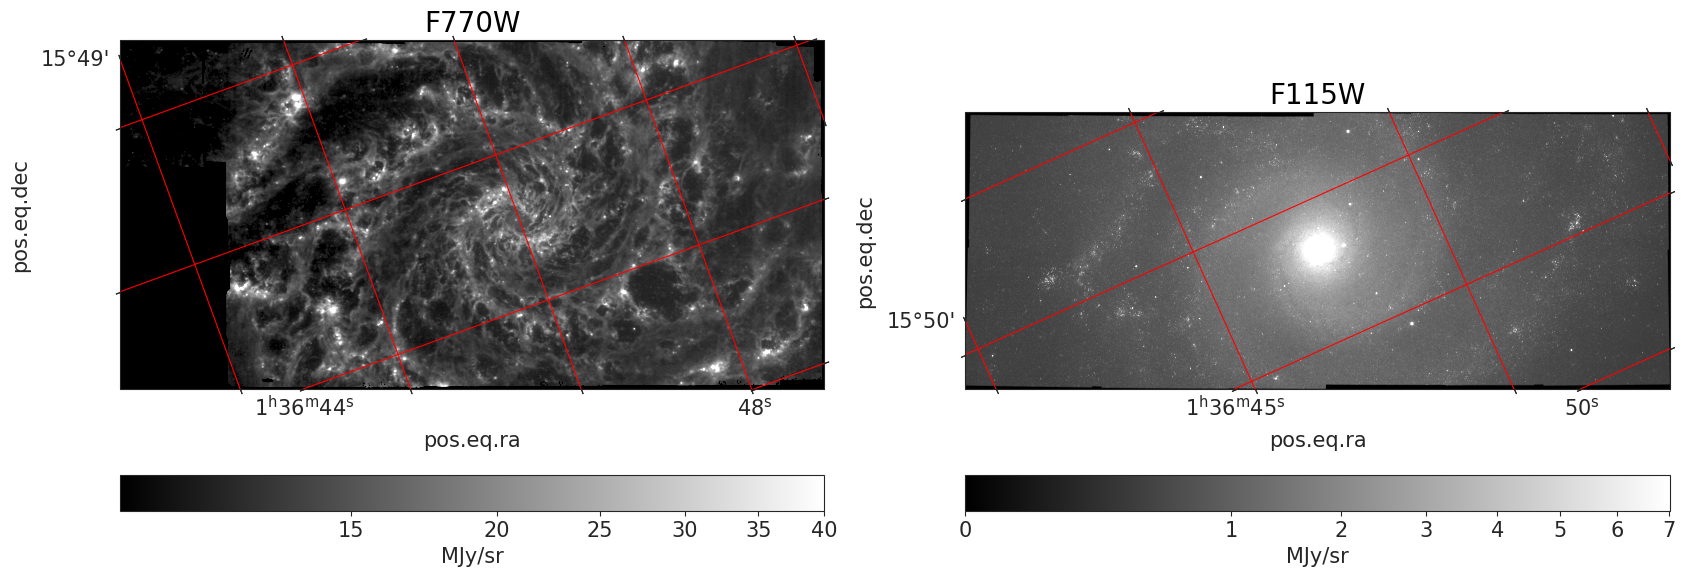

In [125]:
plt.figure(figsize=(20, 12))

ax1= plt.subplot(1, 2, 1, projection=wcs_m)

ax1.set_title(filt_m, fontdict=font2)
norm = simple_norm(data_m, 'sqrt',min_cut=12, max_cut = 40)

img = ax1.imshow(data_m, norm = norm, cmap='gray')
ax1.grid(color='red', ls='solid')
cb = plt.colorbar(img, orientation='horizontal', anchor = (0.5, 1.5))
cb.set_label(f"{imh_m['BUNIT']}")

ax2 = plt.subplot(1, 2, 2, projection=wcs_n)

ax2.set_title(filt_n, fontdict=font2)
norm = simple_norm(data_n, 'sqrt',percent=99.)

img = ax2.imshow(data_n, norm = norm, cmap='gray')
ax2.grid(color='red', ls='solid')
cb = plt.colorbar(img, orientation='horizontal', anchor = (0.5, 1.5))
cb.set_label(f"{imh_n['BUNIT']}")

In [18]:
# EPSF Region= ra=24.2032976, dec= 15.7501192
#Bubble = ra=24.1862604, dec=15.7721020,

In [126]:
pos = SkyCoord(ra=24.1862604, dec=15.7721020, unit='deg')

In [127]:
cutout_m = Cutout2D(data_m,pos,size = 50*u.arcsec, wcs = wcs_m)
cutout_n = Cutout2D(data_n,pos,size = 50*u.arcsec, wcs = wcs_n)

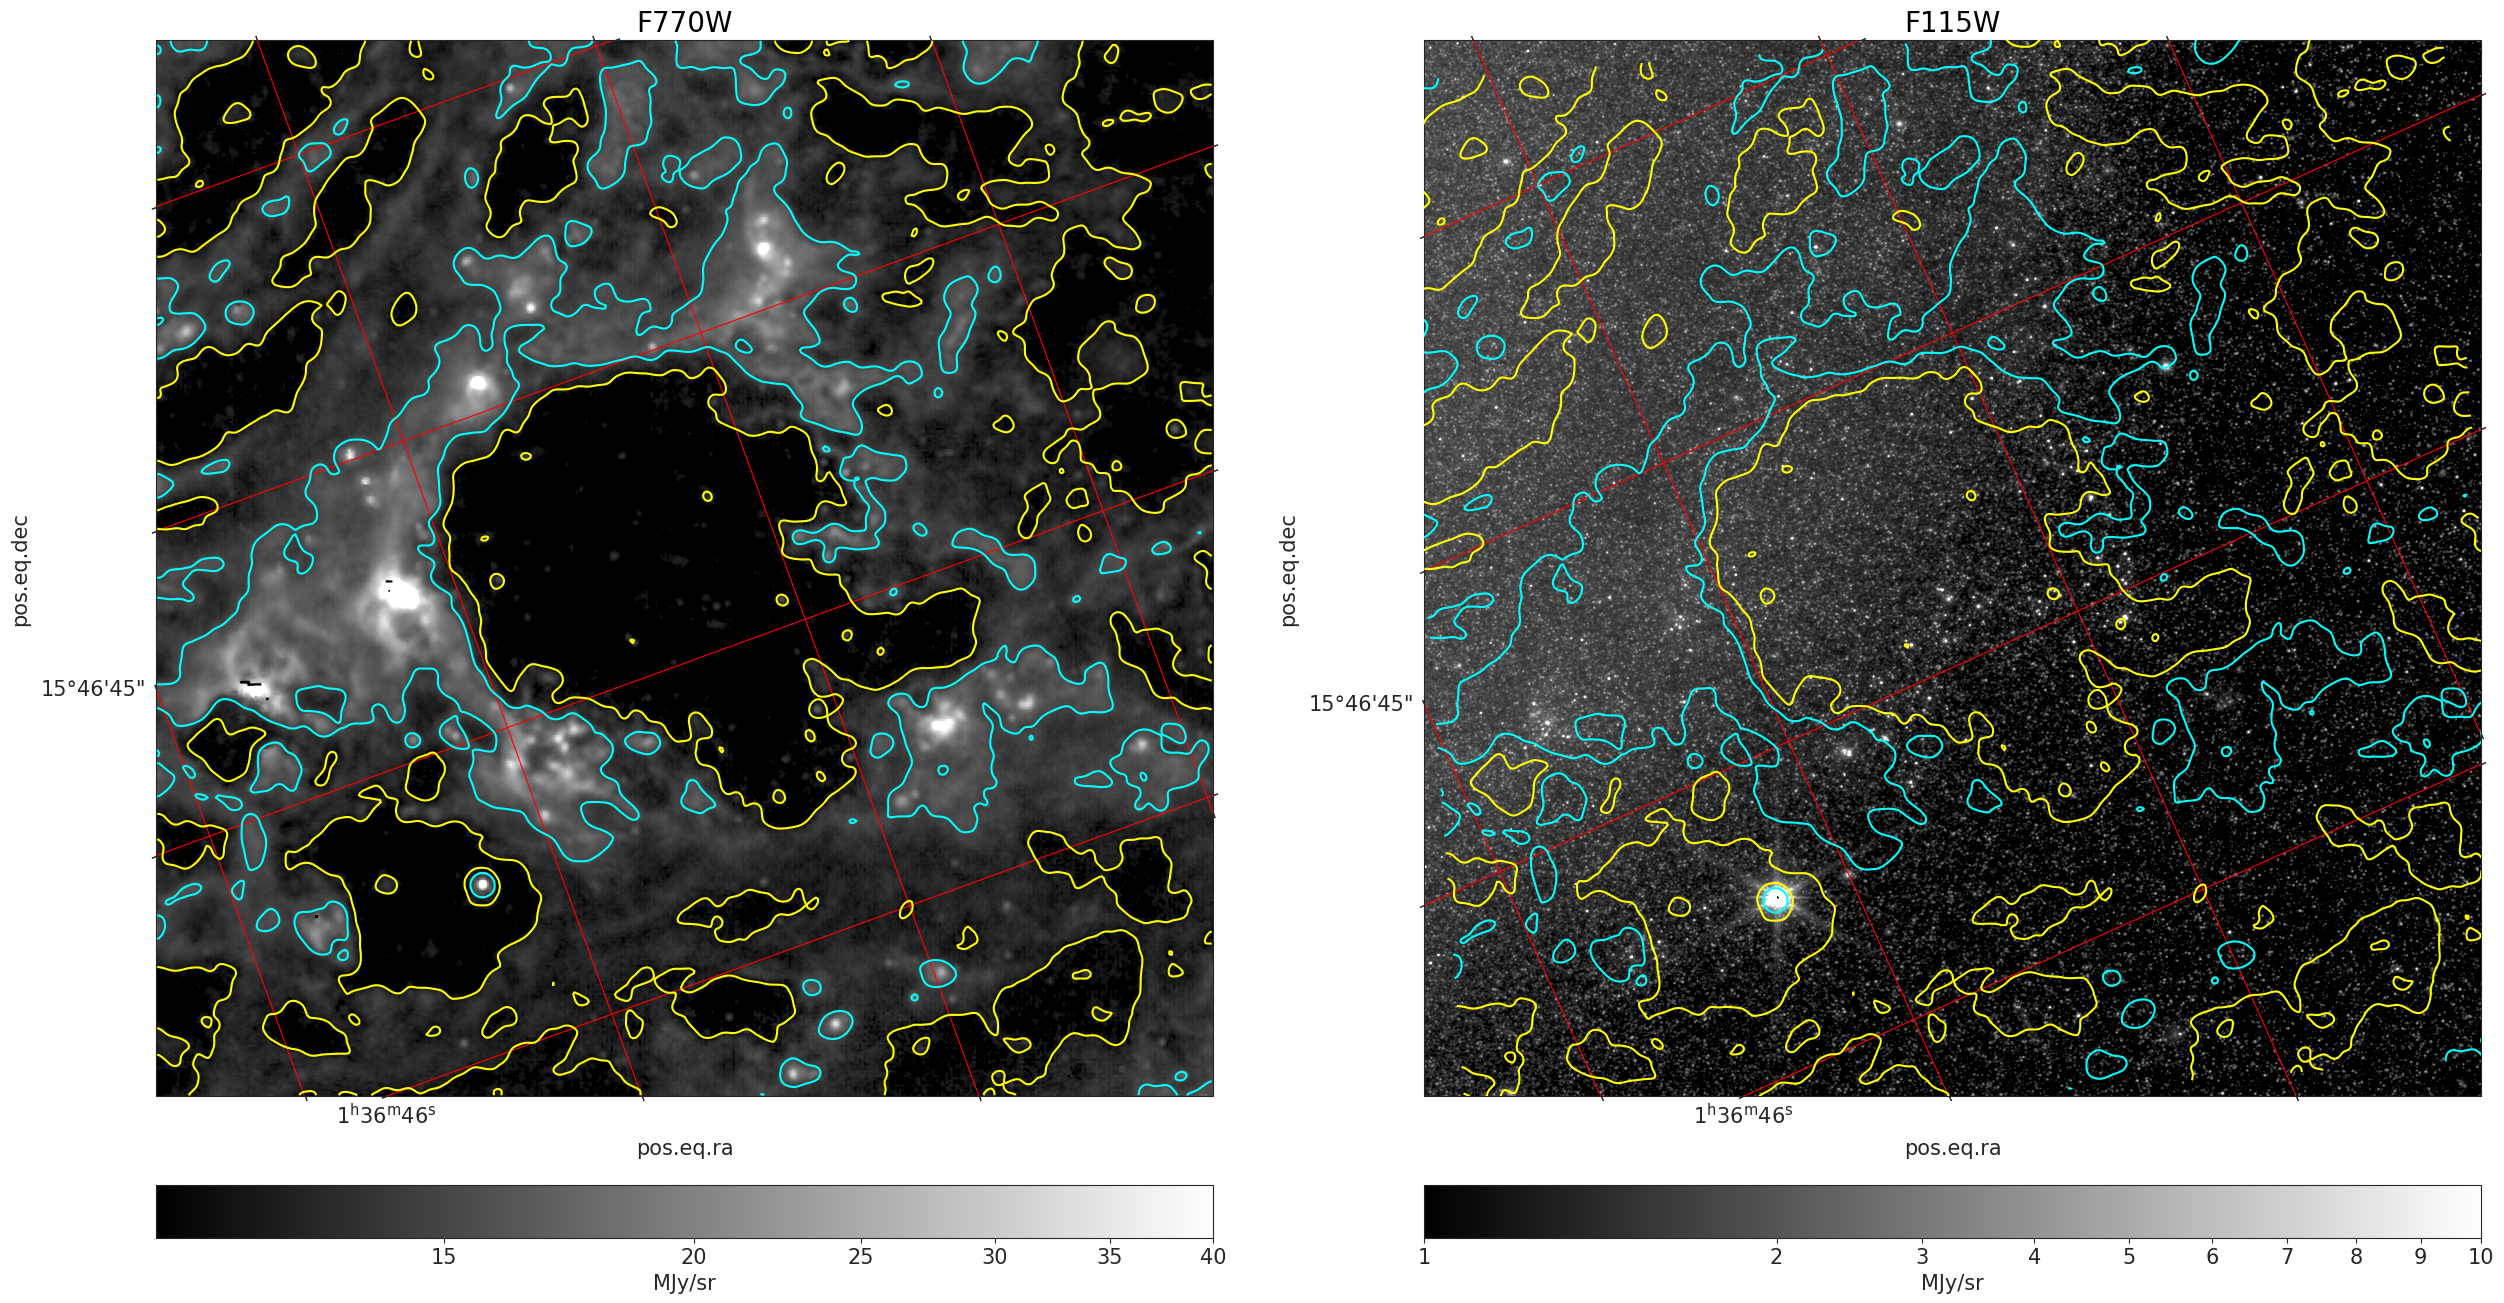

In [128]:
plt.figure(figsize=(30, 20))

ax1 = plt.subplot(1, 2, 1, projection=cutout_m.wcs)

ax1.set_title(filt_m, fontdict=font2)
norm = simple_norm(cutout_m.data, 'sqrt',min_cut=13, max_cut = 40)

img = ax1.imshow(cutout_m.data, norm = norm, cmap='gray')
# MIRI Contours
levels = [13.2,15]
cmap = ListedColormap(['yellow','cyan'])
smooth_data = gaussian_filter(cutout_m.data, 2)
ax1.contour(smooth_data, levels=levels, cmap=cmap)

ax1.grid(color='red', ls='solid')
cb = plt.colorbar(img, orientation='horizontal', anchor = (0.5, 1.8))
cb.set_label(f"{imh_m['BUNIT']}")

ax2 = plt.subplot(1, 2, 2, projection=cutout_n.wcs)

ax2.set_title(filt_n, fontdict=font2)
norm = simple_norm(cutout_n.data, 'sqrt',min_cut = 1, max_cut=10)

img = ax2.imshow(cutout_n.data, norm = norm, cmap='gray')
ax2.contour(smooth_data, levels=levels, cmap=cmap, transform=ax2.get_transform(cutout_m.wcs))
ax2.grid(color='red', ls='solid')
cb = plt.colorbar(img, orientation='horizontal', anchor = (0.5, 1.8))
cb.set_label(f"{imh_n['BUNIT']}")

## **Photutils**

### **PSF**

#### **Synthetic PSF**

In [ ]:

psf_webbpsf_single = create_psf_model(det=det_n, filt=filt_n, fov=51, source=None, create_grid=False, save_psf=False,
                                      detsampled=False)

In [ ]:
psf_filename

In [23]:
filts = [i.split('_')[2] for i in glob.glob(os.path.join(psfs_dir, "*fits"))]
if filt_n not in filts:
    psf_webbpsf_grid = create_psf_model(det=det_n, filt=filt_n, fov=51, source=None, create_grid=True, num=16,
                                        save_psf=True, detsampled=False, all_detectors=False)
else:
    psf_filename = glob.glob(os.path.join('PSF_MODELS/',f'PSF_{filt_n}*{det_n.lower()}.fits'))
    
    with fits.open(psf_filename) as hdu:
        psf_webbpsf_grid = to_griddedpsfmodel(hdu, ext_data=0, ext_header=0)

    Position 11/16 centroid: (101.47268544332137, 101.14751698979718)
    Position 12/16: (1365, 2047) pixels
    Position 12/16 centroid: (101.51353839948916, 101.13062245129738)
    Position 13/16: (2047, 0) pixels
    Position 13/16 centroid: (101.2108005957548, 100.97423436387648)
    Position 14/16: (2047, 682) pixels
    Position 14/16 centroid: (101.41800812922367, 101.05904581953932)
    Position 15/16: (2047, 1365) pixels
    Position 15/16 centroid: (101.43167250438837, 101.15144017068829)
    Position 16/16: (2047, 2047) pixels
    Position 16/16 centroid: (101.48090652216469, 101.18425386286945)
  Saving file: PSF_MODELS/PSF_F200W_samp4_fov51_npsfs16_nrcb4.fits


In [ ]:
webbpsf.gridded_library.display_psf_grid(psf_webbpsf_grid, zoom_in=False, figsize=(14, 10))

#### **Empirical PSF**

In [ ]:
tic = time.perf_counter()

# Source Detection

found_stars, data_out,bkg = find_stars(cutout_n.data, det=det_n, filt=filt_n, threshold=5, smoothen=False,ZP=ZAB_n)

toc = time.perf_counter()

print("Elapsed Time for finding stars:", toc - tic)

In [ ]:
# Source Selection
plt.figure(figsize=(12, 8))
plt.clf()

ax1 = plt.subplot(2, 1, 1)

ax1.set_xlabel('mag', fontdict=font2)
ax1.set_ylabel('sharpness', fontdict=font2)

xlim0 = np.min(found_stars['mag']) - 0.25
xlim1 = np.max(found_stars['mag']) + 0.25
ylim0 = np.min(found_stars['sharpness']) - 0.15
ylim1 = np.max(found_stars['sharpness']) + 0.15

ax1.set_xlim(xlim0, xlim1)
ax1.set_ylim(ylim0, ylim1)

ax1.xaxis.set_major_locator(ticker.AutoLocator())
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax1.scatter(found_stars['mag'], found_stars['sharpness'], s=10, color='k')

sh_inf = 0.58
sh_sup = 0.65
mag_inf = 24
mag_sup = 27

ax1.plot([xlim0, xlim1], [sh_sup, sh_sup], color='r', lw=3, ls='--')
ax1.plot([xlim0, xlim1], [sh_inf, sh_inf], color='r', lw=3, ls='--')
ax1.plot([mag_inf, mag_inf], [ylim0, ylim1], color='r', lw=3, ls='--')
ax1.plot([mag_sup, mag_sup], [ylim0, ylim1], color='r', lw=3, ls='--')

ax2 = plt.subplot(2, 1, 2)

ax2.set_xlabel('mag', fontdict=font2)
ax2.set_ylabel('roundness', fontdict=font2)

ylim0 = np.min(found_stars['roundness2']) - 0.25
ylim1 = np.max(found_stars['roundness2']) - 0.25

ax2.set_xlim(xlim0, xlim1)
ax2.set_ylim(ylim0, ylim1)

ax2.xaxis.set_major_locator(ticker.AutoLocator())
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.yaxis.set_major_locator(ticker.AutoLocator())
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())

round_inf = -0.20
round_sup = 0.20

ax2.scatter(found_stars['mag'], found_stars['roundness2'], s=10, color='k')

ax2.plot([xlim0, xlim1], [round_sup, round_sup], color='r', lw=3, ls='--')
ax2.plot([xlim0, xlim1], [round_inf, round_inf], color='r', lw=3, ls='--')
ax2.plot([mag_inf, mag_inf], [ylim0, ylim1], color='r', lw=3, ls='--')
ax2.plot([mag_sup, mag_sup], [ylim0, ylim1], color='r', lw=3, ls='--')

plt.tight_layout()

In [ ]:
plt.figure(figsize=(5,5))
x = found_stars[(found_stars['mag']>24.95) & (found_stars['mag']<26.05)]['sharpness'].value
y,x,_= plt.hist(x,bins=50)
x_mid =  0.5*(x[:-1] + x[1:])
init = models.Gaussian1D()
fit = LevMarLSQFitter()
model = fit(init, x_mid,y)
plt.plot(x,model(x), color='red')
plt.title(f'Roundess at mag=1')
plt.xlabel('Roundess')
plt.ylabel('Counts')
plt.legend(['Data',f'Gaussian Fit\n' + \
                        r'$\mu$ = ' + f'{np.round(model.mean.value,3)}\n'+ \
                        r'$\sigma$ = ' + f'{np.round(model.stddev.value,3)}'])

In [ ]:
model.mean.value - 3*model.stddev.value, model.mean.value + 3*model.stddev.value

In [ ]:
found_table_sel = select_stars(found_stars, mag_inf, mag_sup, round_inf, round_sup, sh_inf, sh_sup, min_sep=12)

In [ ]:
positions = np.transpose([found_table_sel['xcentroid'], found_table_sel['ycentroid']])
apers = CircularAperture(positions, 6)
ax = plt.subplot(1,1,1)
ax.imshow(cutout_n.data, norm=norm, cmap='gray')
apers.plot(ax, color='red');

In [ ]:
# Building Empirical PSF
epsf = build_epsf(cutout_n.data, det=det_n, filt=filt_n, size=15, found_table=found_table_sel, oversample=4, iters=10)

In [ ]:
plt.imshow(epsf.data, norm=col.LogNorm())

### **Photometry**

In [ ]:
psf_phot_table, residual_image, phot, bkg = psf_phot(data=cutout_n.data, det=det_n, filt=filt_n, th=5, psf=psf_webbpsf_grid,
                                                fit_shape=(15,15), min_sep=1, save_residuals=True, header=imh_n,
                                                save_output=True, maxiters=1,ZP=ZAB_n,sub_shape=(15,15), save_bkg=True)

In [ ]:
m = np.arange(22,28,0.05)
psf = psf_webbpsf_grid.data[0].max()
flux_max = 10**(-0.4*(m-ZAB_n))
bkg_median = bkg.background_median

lim_mag = m[flux_max<5*bkg_median][0]
print(f'Limiting Magnitude for SNR = 5 : {np.round(lim_mag,4)}')

In [ ]:
bkg.background_median

In [ ]:
plt.figure(figsize=(7,5))
mag = psf_phot_table['mag']
mag_err = psf_phot_table['mag_err']
plt.scatter(mag,mag_err,s=1, color='black')
plt.xlabel('mag')
plt.ylabel('mag_err')

In [ ]:
fig = plt.figure(figsize=(20,10))
ax= fig.subplots(1,2)

ax[0].plot(m,flux_max,'-')
ax[0].plot([22,28],[5*bkg_median,5*bkg_median], 'r--')
ax[0].set_ylabel('Peak flux')
ax[0].set_xlabel('mag (AB)')
ax[0].annotate(f'mag limit : {np.round(lim_mag,4)}', (lim_mag, 5*bkg_median ))

ax[1].plot(m[:-1],flux_max[:-1] - flux_max[1:],'-')
ax[1].plot([22,28],[5*bkg_median,5*bkg_median], 'r--')
ax[1].set_ylabel(f'Peak flux difference for {np.round(m[1]-m[0],2)} mag difference ')
ax[1].set_xlabel('mag (AB)')

In [ ]:
plt.figure(figsize=(7,5))
mags = psf_phot_table['mag']
plt.hist(mags, bins=np.arange(mags.min(), mags.max(), 0.05 ))
plt.xlabel('mag')
plt.ylabel('Counts');

In [ ]:
plt.figure(figsize=(7,5))
x = psf_phot_table['mag']
y = psf_phot_table['cfit']

plt.scatter(x,y,s=1)

In [ ]:
psf_phot_table

In [29]:
dict_images

{'NRCA1': {},
 'NRCA2': {},
 'NRCA3': {},
 'NRCA4': {},
 'NRCA5': {},
 'NRCB1': {},
 'NRCB2': {},
 'NRCB3': {},
 'NRCB4': {'F115W': {'images': ['../data/NGC 628/JWST/jw01783-o004_t008_nircam_clear-f115w/jw01783-o004_t008_nircam_clear-f115w_i2d.fits']},
  'F150W': {'images': ['../data/NGC 628/JWST/jw01783-o004_t008_nircam_clear-f150w/jw01783-o004_t008_nircam_clear-f150w_i2d.fits']},
  'F187N': {'images': ['../data/NGC 628/JWST/jw01783-o004_t008_nircam_clear-f187n/jw01783-o004_t008_nircam_clear-f187n_i2d.fits']},
  'F200W': {'images': ['../data/NGC 628/JWST/jw01783-o004_t008_nircam_clear-f200w/jw01783-o004_t008_nircam_clear-f200w_i2d.fits']},
  'F277W': {'images': ['../data/NGC 628/JWST/jw01783-o004_t008_nircam_clear-f277w/jw01783-o004_t008_nircam_clear-f277w_i2d.fits']},
  'F335M': {'images': ['../data/NGC 628/JWST/jw01783-o004_t008_nircam_clear-f335m/jw01783-o004_t008_nircam_clear-f335m_i2d.fits']},
  'F444W': {'images': ['../data/NGC 628/JWST/jw01783-o004_t008_nircam_clear-f444w/jw017

## **Photomertry using DOLPHOT**

In [136]:
input_path = dict_images[det_n][filt_n]['images'][0]

In [137]:
if not os.path.exists(f"../PHOT_OUTPUT/{filt_n}/"):
    os.mkdir(f"../PHOT_OUTPUT/{filt_n}")
os.system(f"cp {input_path} ../PHOT_OUTPUT/{filt_n}/data.fits")
os.listdir(f"../PHOT_OUTPUT/{filt_n}")

['data.fits']

### **Running NIRCAMMASK**

In [138]:
os.system(f"nircammask ../PHOT_OUTPUT/{filt_n}/data.fits")

Reading FITS file ../PHOT_OUTPUT/F115W/data.fits
Reading IMAGE extension: 11417x4486
Reading IMAGE extension: 11417x4486
Reading IMAGE extension: 11417x4486x2
Reading IMAGE extension: 11417x4486
Reading IMAGE extension: 11417x4486
Reading IMAGE extension: 11417x4486
Reading IMAGE extension: 11417x4486
Reading BINTABLE extension: 3914x64
Reading BINTABLE extension: 288555
Writing FITS file ../PHOT_OUTPUT/F115W/data.fits
Writing IMAGE extension: 11417x4486


0

### **Creating Cutout**
In this step we also change the detector in the header to force DOLPHOT into doing photometry on drizzled image

In [139]:
os.system(f"python ../dolphot_convert.py --f ../PHOT_OUTPUT/{filt_n}/data.fits --d 'NRCA3' --c True")

Set DATE-BEG to '2022-07-29T06:30:09.483' from MJD-BEG.
Set DATE-AVG to '2022-07-29T07:50:56.201' from MJD-AVG.
Set DATE-END to '2022-07-29T09:11:42.893' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -35.423659 from OBSGEO-[XYZ].
Set OBSGEO-H to 1708322100.317 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Reading file  ../PHOT_OUTPUT/F115W/data.fits
Using user defined detector NRCA3
Saving ../PHOT_OUTPUT/F115W/data_conv.fits


0

### **Calculating Sky Background**

In [140]:
os.system(f"calcsky ../PHOT_OUTPUT/{filt_n}/data_conv 10 25 2 2.25 2.00")

Reading FITS file ../PHOT_OUTPUT/F115W/data_conv.fits
Reading IMAGE extension: 1594x1594
  BAD=-1.00 SAT=65535.00
  BAD=-1625.41 SAT=1561296.50
......................................................................
Writing FITS file ../PHOT_OUTPUT/F115W/data_conv.sky.fits
Writing IMAGE extension: 1594x1594


0

### **Running DOLPHOT**

In [141]:
with open("../params/dolphot.param") as f:
    dat = f.readlines()
    
dat[4] = f'img1_file = ../PHOT_OUTPUT/{filt_n}/data_conv            #image 1\n'

with open("../params/dolphot.param", 'w', encoding='utf-8') as f:
    f.writelines(dat)

In [142]:
os.system(f"dolphot ../PHOT_OUTPUT/{filt_n}/out -p../params/dolphot.param")

Reading FITS file ../PHOT_OUTPUT/F115W/data_conv.fits
Reading IMAGE extension: 1594x1594
  GAIN=2.05 EXP=2920s NOISE=11.46 BAD=-1625.41 SAT=1561296.50
** Extension 1, Chip 1 **
CD matrix not found; using PC matrix instead
reference rmsi = 0.000039, rmsf = 0.000002
Finding stars: .......
359286 found
132592 stars eliminated
23048 stars eliminated
8841 stars eliminated
4853 stars eliminated
3096 stars eliminated
2160 stars eliminated
1472 stars eliminated
1097 stars eliminated
816 stars eliminated
658 stars eliminated
464 stars eliminated
375 stars eliminated
314 stars eliminated
99 PSF stars; 9277 neighbors
Central pixel PSF adjustments:
image 1: 99 stars, -0.112272
558 stars eliminated
9531 stars eliminated
3553 stars eliminated
1191 stars eliminated
280 stars eliminated
310 stars eliminated
168 stars eliminated
35 stars eliminated
27 stars eliminated
18 stars eliminated
2 stars eliminated
3 stars eliminated
4 stars eliminated
Aperture corrections:
image 1: 200 total aperture stars
  1

0

### **Photometry Table**

In [143]:
os.system(f"python ../to_table.py --f ../PHOT_OUTPUT/{filt_n}/out")

0

In [144]:
phot_result = Table.read(f"../PHOT_OUTPUT/{filt_n}/photometry.fits")

In [145]:
phot_table = phot_result[(phot_result['type']<2) & (phot_result['mag_vega']<32) & (phot_result['SNR']>5)]

In [146]:
phot_table = phot_table[(abs(phot_table['sharpness'])<0.5)] 

In [147]:
hdu = fits.open(f"../PHOT_OUTPUT/{filt_n}/data_conv.fits")[1]

In [148]:
wcs = WCS(hdu.header)

Set OBSGEO-B to   -35.423659 from OBSGEO-[XYZ].
Set OBSGEO-H to 1708322100.317 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [149]:
positions = np.transpose([phot_table['x'], phot_table['y']])

In [150]:
coords = np.array(wcs.pixel_to_world_values(positions))
phot_table['ra'] = coords[:,0]
phot_table['dec'] = coords[:,1]

In [151]:
phot_table.write(f"../PHOT_OUTPUT/{filt_n}/photometry_filt.fits",overwrite=True)

In [152]:
len(phot_table)

155860

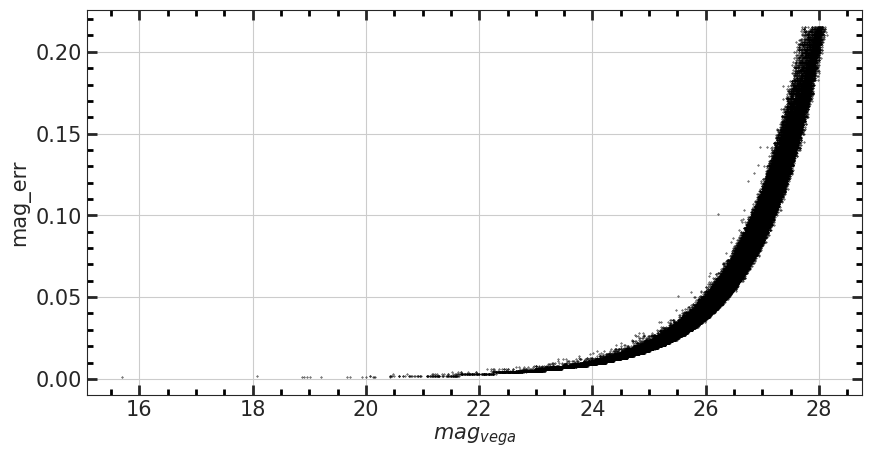

In [153]:
x = phot_table['mag_vega']
y = phot_table['mag_err']

fig = plt.figure(figsize=(10,5))
ax = fig.subplots(1,1)
ax.scatter(x,y, s =0.5,marker = '.', color='black')
ax.set_xlabel(r'$mag_{vega}$')
ax.set_ylabel('mag_err')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")

plt.grid()

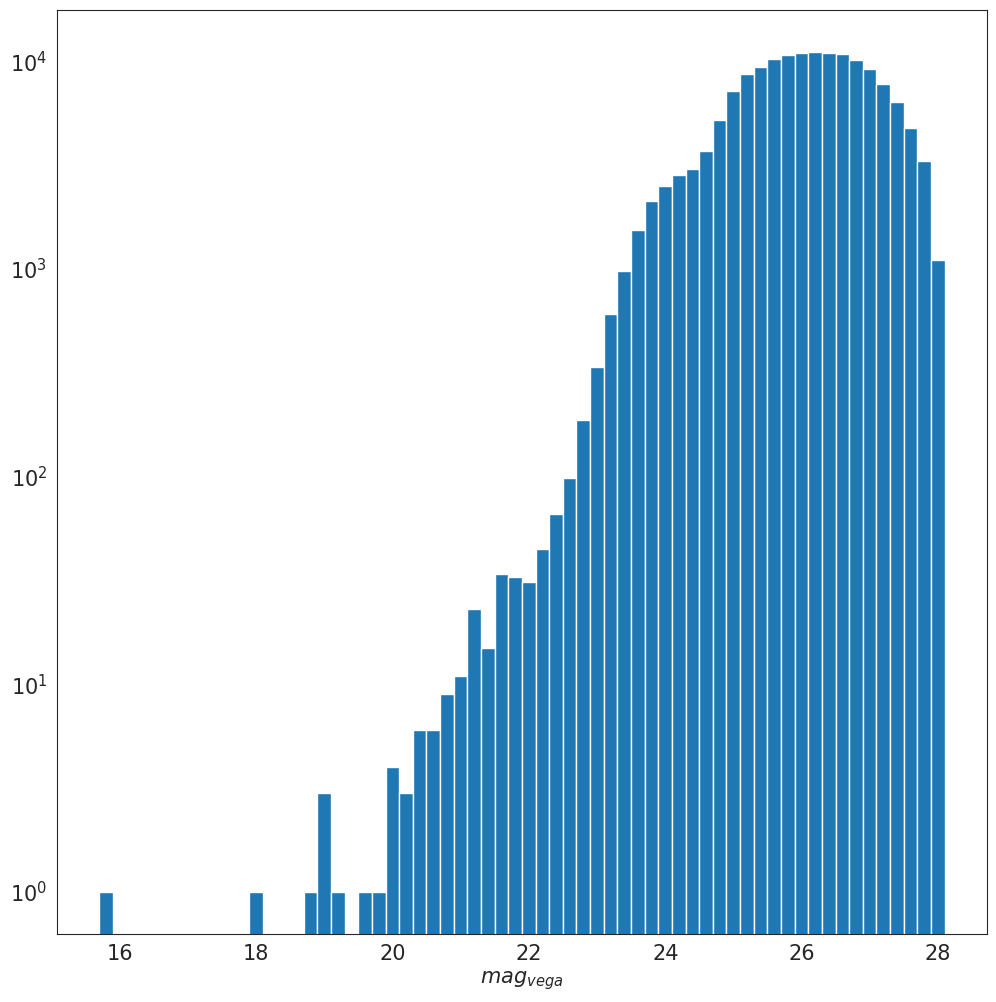

In [154]:
x = phot_table['mag_vega']

plt.hist(x, bins=np.arange(x.min(), x.max(),0.2))
plt.yscale('log')
plt.xlabel(r'$mag_{vega}$');

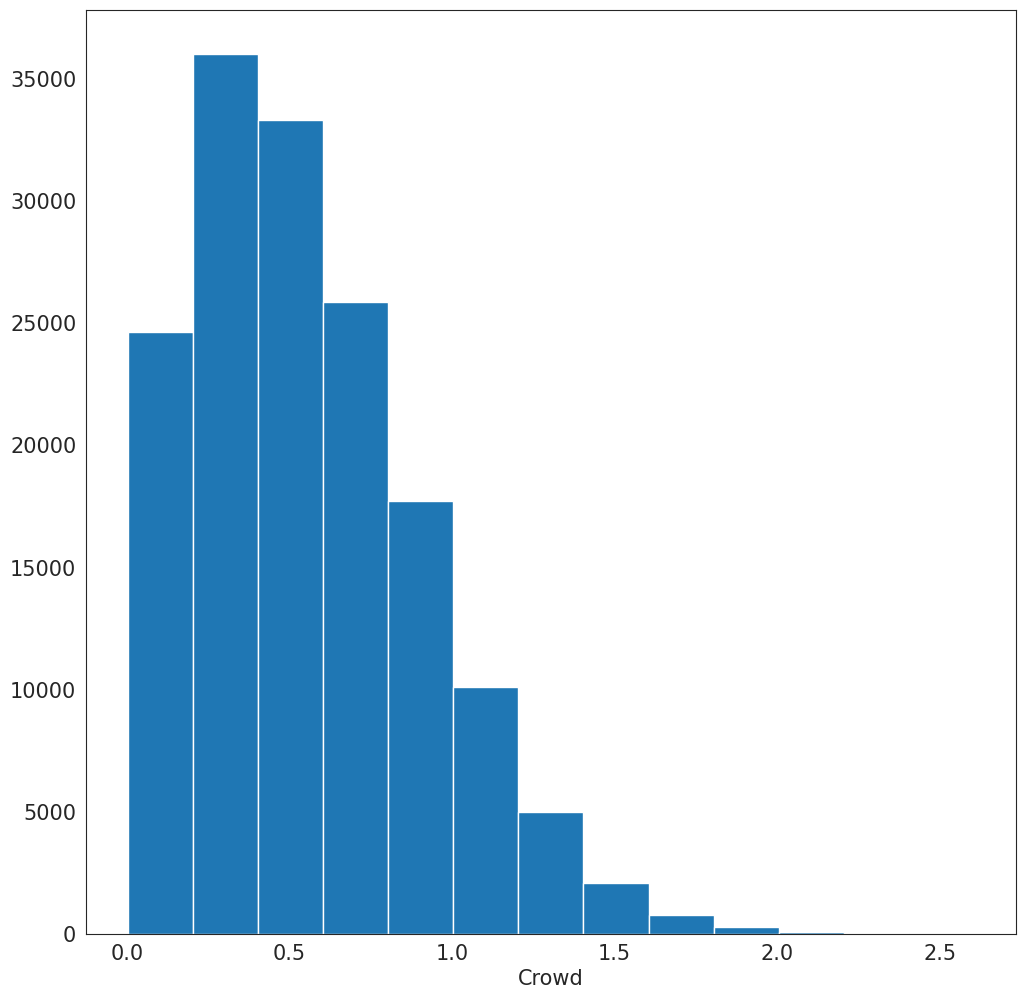

In [155]:
x = phot_table['obj_crowd']

plt.hist(x, bins=np.arange(x.min(), x.max(),0.2))
plt.xlabel('Crowd');

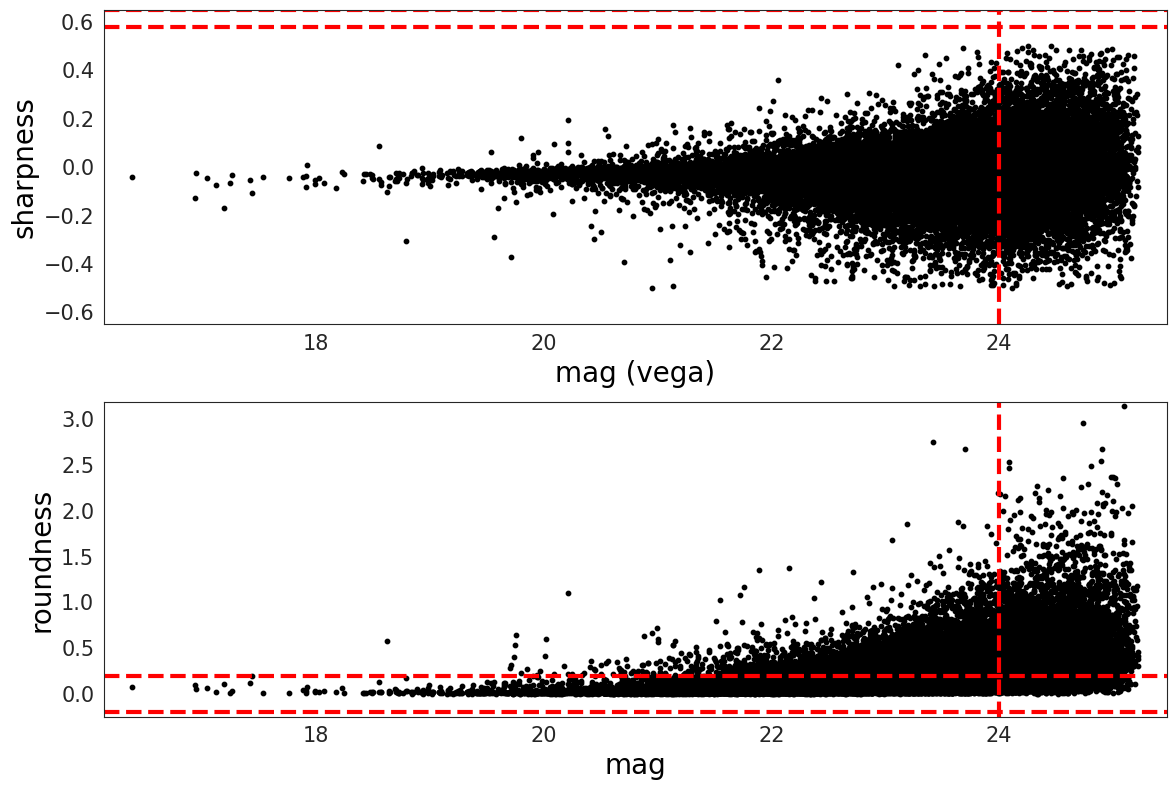

In [106]:
# Source Selection
plt.figure(figsize=(12, 8))
plt.clf()

ax1 = plt.subplot(2, 1, 1)

ax1.set_xlabel('mag (vega)', fontdict=font2)
ax1.set_ylabel('sharpness', fontdict=font2)

xlim0 = np.min(phot_table['mag_vega']) - 0.25
xlim1 = np.max(phot_table['mag_vega']) + 0.25
ylim0 = np.min(phot_table['sharpness']) - 0.15
ylim1 = np.max(phot_table['sharpness']) + 0.15

ax1.set_xlim(xlim0, xlim1)
ax1.set_ylim(ylim0, ylim1)

ax1.xaxis.set_major_locator(ticker.AutoLocator())
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax1.scatter(phot_table['mag_vega'], phot_table['sharpness'], s=10, color='k')

sh_inf = 0.58
sh_sup = 0.65
mag_inf = 24
mag_sup = 27

ax1.plot([xlim0, xlim1], [sh_sup, sh_sup], color='r', lw=3, ls='--')
ax1.plot([xlim0, xlim1], [sh_inf, sh_inf], color='r', lw=3, ls='--')
ax1.plot([mag_inf, mag_inf], [ylim0, ylim1], color='r', lw=3, ls='--')
ax1.plot([mag_sup, mag_sup], [ylim0, ylim1], color='r', lw=3, ls='--')

ax2 = plt.subplot(2, 1, 2)

ax2.set_xlabel('mag', fontdict=font2)
ax2.set_ylabel('roundness', fontdict=font2)

ylim0 = np.min(phot_table['obj_roundness']) - 0.25
ylim1 = np.max(phot_table['obj_roundness']) - 0.25

ax2.set_xlim(xlim0, xlim1)
ax2.set_ylim(ylim0, ylim1)

ax2.xaxis.set_major_locator(ticker.AutoLocator())
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.yaxis.set_major_locator(ticker.AutoLocator())
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())

round_inf = -0.20
round_sup = 0.20

ax2.scatter(phot_table['mag_vega'], phot_table['roundness'], s=10, color='k')

ax2.plot([xlim0, xlim1], [round_sup, round_sup], color='r', lw=3, ls='--')
ax2.plot([xlim0, xlim1], [round_inf, round_inf], color='r', lw=3, ls='--')
ax2.plot([mag_inf, mag_inf], [ylim0, ylim1], color='r', lw=3, ls='--')
ax2.plot([mag_sup, mag_sup], [ylim0, ylim1], color='r', lw=3, ls='--')

plt.tight_layout()

# **CMD**

In [14]:
tab = Table.read("../PHOT_OUTPUT/f115w_f200w_f335m_f444w.fits")

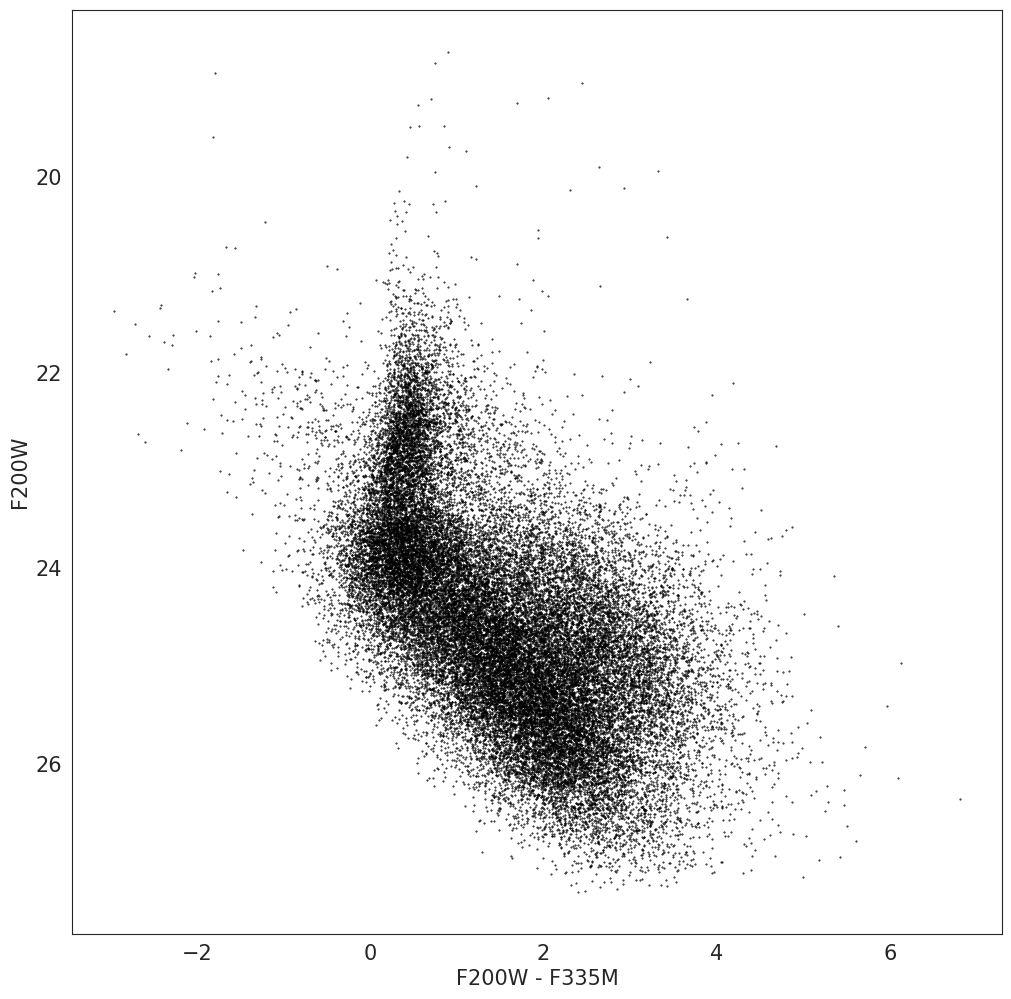

In [15]:
x = tab['mag_vega_F200W'] - tab['mag_vega_F335M']
y = tab['mag_vega_F200W']

ax = plt.subplot(1,1,1)
ax.scatter(x,y, s=0.2, color='black')
ax.set_xlabel("F200W - F335M")
ax.set_ylabel("F200W")
ax.invert_yaxis()

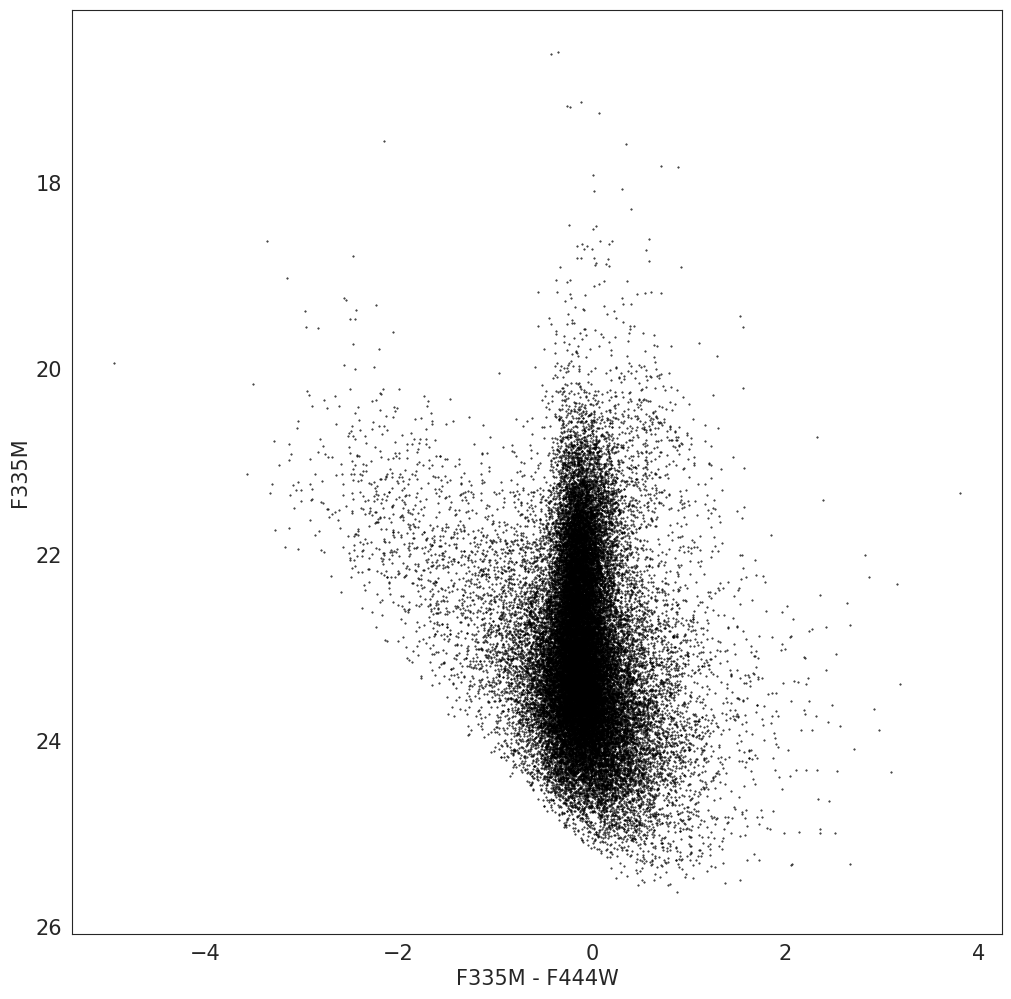

In [16]:
x = tab['mag_vega_F335M'] - tab['mag_vega_F444W']
y = tab['mag_vega_F335M']

ax = plt.subplot(1,1,1)
ax.scatter(x,y, s=0.2, color='black')
ax.set_xlabel("F335M - F444W")
ax.set_ylabel("F335M")
ax.invert_yaxis()

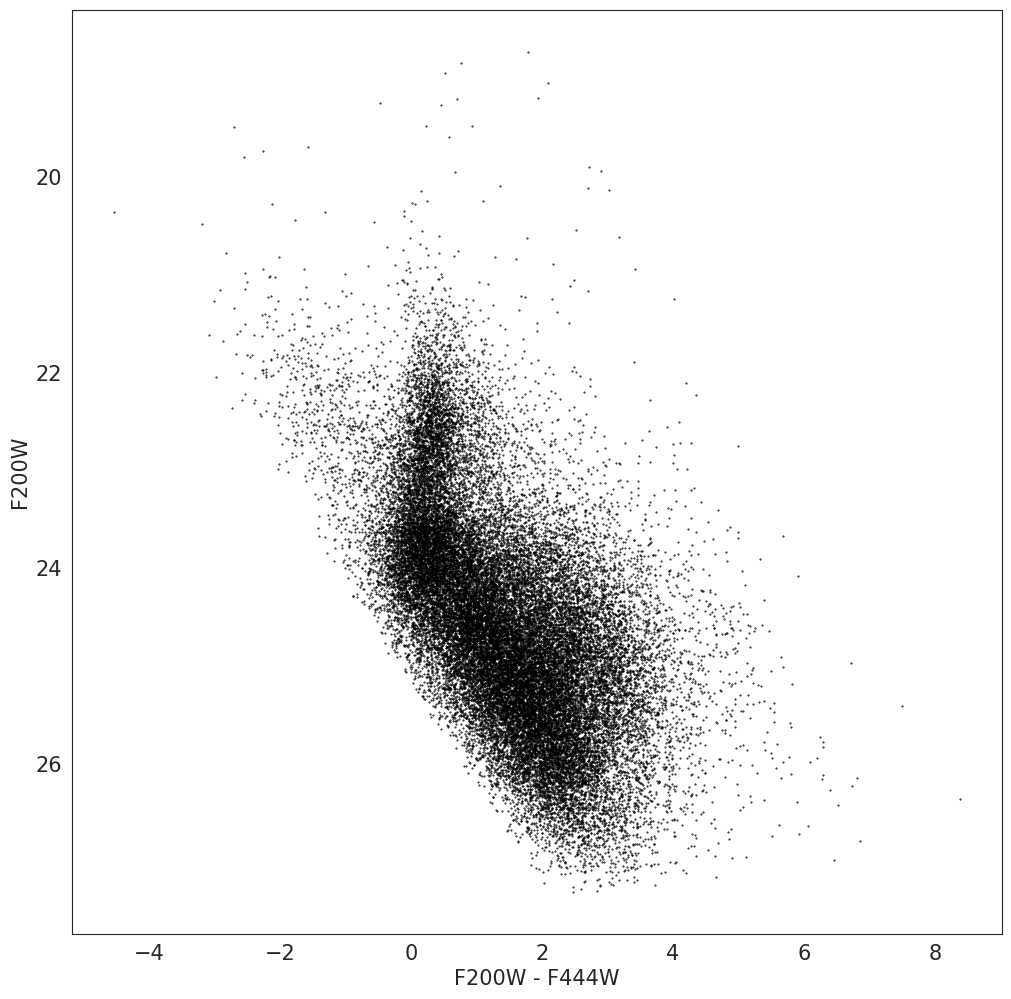

In [17]:
x = tab['mag_vega_F200W'] - tab['mag_vega_F444W']
y = tab['mag_vega_F200W']

ax = plt.subplot(1,1,1)
ax.scatter(x,y, s=0.2, color='black')
ax.set_xlabel("F200W - F444W")
ax.set_ylabel("F200W")
ax.invert_yaxis()

Text(0, 0.5, 'F200W - F335M')

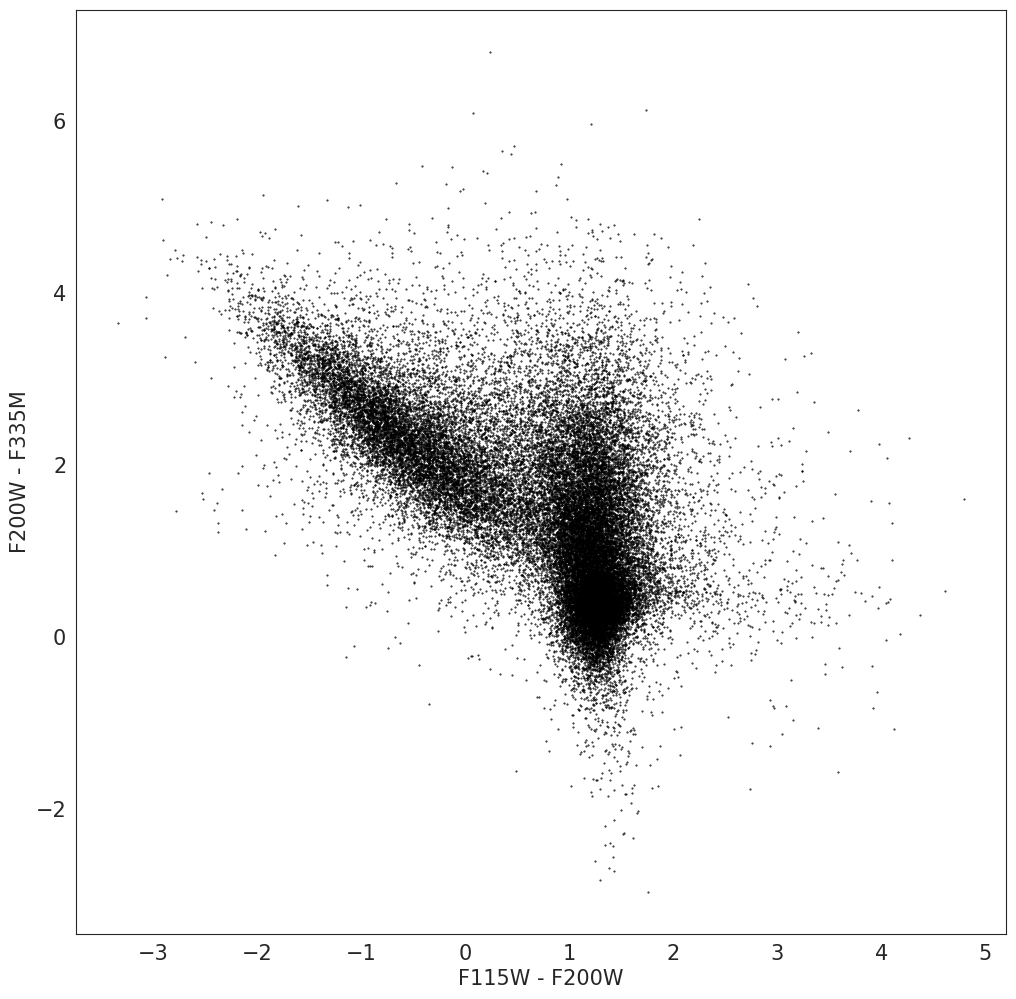

In [21]:
x = tab['mag_vega_F115W'] - tab['mag_vega_F200W']
y = tab['mag_vega_F200W'] - tab['mag_vega_F335M']

ax = plt.subplot(1,1,1)
ax.scatter(x,y, s=0.2, color='black')
ax.set_xlabel("F115W - F200W")
ax.set_ylabel("F200W - F335M")

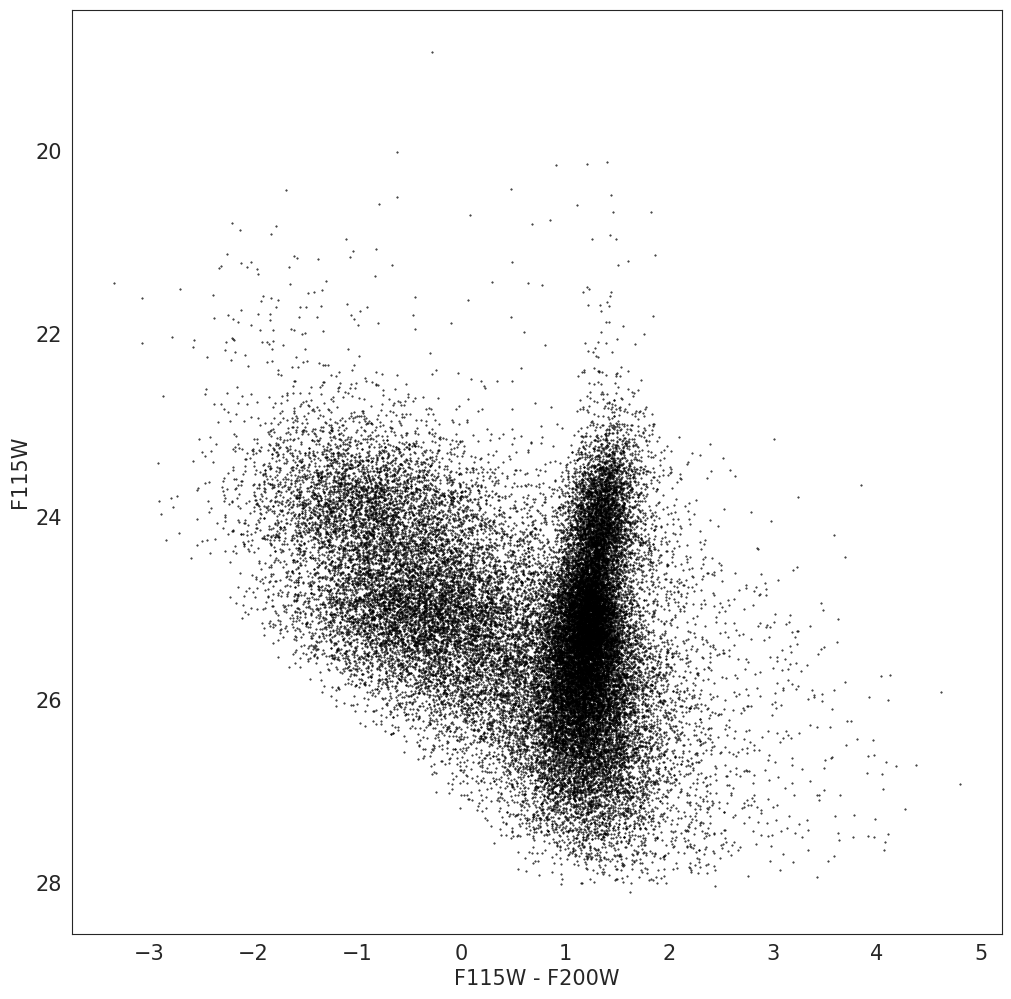

In [22]:
x = tab['mag_vega_F115W'] - tab['mag_vega_F200W']
y = tab['mag_vega_F115W']

ax = plt.subplot(1,1,1)
ax.scatter(x,y, s=0.2, color='black')
ax.set_xlabel("F115W - F200W")
ax.set_ylabel("F115W")
ax.invert_yaxis()

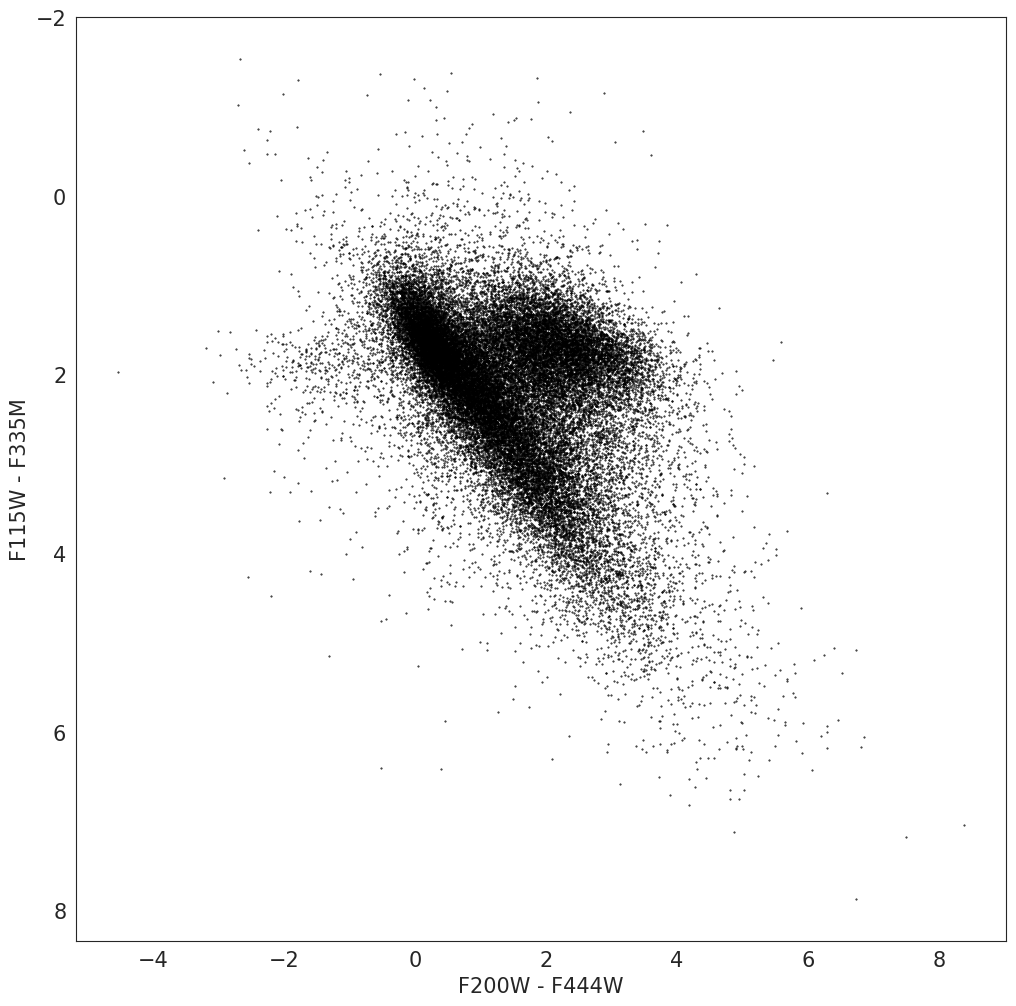

In [19]:
x = tab['mag_vega_F200W'] - tab['mag_vega_F444W']
y = tab['mag_vega_F115W'] - tab['mag_vega_F335M']

ax = plt.subplot(1,1,1)
ax.scatter(x,y, s=0.2, color='black')
ax.set_xlabel("F200W - F444W")
ax.set_ylabel("F115W - F335M")
ax.invert_yaxis()

# **Astrometry using Astrometry.net**

In [ ]:
positions = np.transpose([psf_phot_table['x_fit'].value, psf_phot_table['y_fit'].value])

In [ ]:
coords = np.array(wcs_n.pixel_to_world_values(positions))
psf_phot_table['ra'] = coords[:,0]
psf_phot_table['dec'] = coords[:,1]

In [ ]:
psf_phot_results = psf_phot_table[(psf_phot_table['flux_fit']>0) & (psf_phot_table['flags']!=8)]

In [ ]:
psf_phot_results['mag'] = ZAB_n - 2.5*np.log10(psf_phot_results['flux_fit'])

In [ ]:
psf_phot_results['mag_err'] = 2.5/np.log(10)*psf_phot_results['flux_err']/psf_phot_results['flux_fit']

In [ ]:
psf_phot_results['SNR'] = psf_phot_results['flux_fit']/psf_phot_results['flux_err']

In [ ]:
psf_phot_results.write(f'NGC_628_{filt_n}_PSF_Photometry_WebbPSFg.fits',overwrite=True)

In [ ]:
plt.imshow(residual_image, norm= col.LogNorm())
plt.colorbar()